In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sktda
import matplotlib.pyplot as plt

In [2]:
from ripser import ripser
from ripser import Rips
from persim import plot_diagrams

In [3]:
t_sample = pd.read_csv('train.csv')

Normalize the features

In [4]:
t_sample['ip']/=10000
t_sample['channel']/=100
t_sample['os']/=10
t_sample['app']/=10
t_sample['click_time_hour'] = t_sample['click_time'].str[11:13]
t_sample['click_time_hour'] = t_sample['click_time_hour'].astype(int)
t_sample = t_sample.drop(['click_time', 'attributed_time'], axis = 1)

In [5]:
df2=t_sample.copy()

Let's see the correlation matrix. 
The results are pretty intuitive, device and os are related. 
Now, we can either remove one of those or just let the model take care directly.

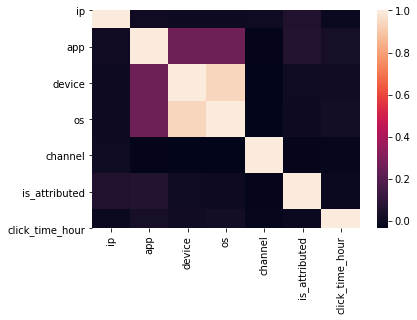

In [6]:
corr = df2.corr()
import seaborn as sns
sns.heatmap(corr)

In [7]:
train2 = df2.sample(n=100000, random_state = 0)

An attempt for kmeans clustering, but since the data is so skewed, it's of no help!

In [8]:
from sklearn.cluster import KMeans
f1=train2['ip'].values
f2=train2['channel'].values
X=np.matrix(list(zip(f1,f2)))
kmeans=KMeans(n_clusters=2).fit_predict(X)

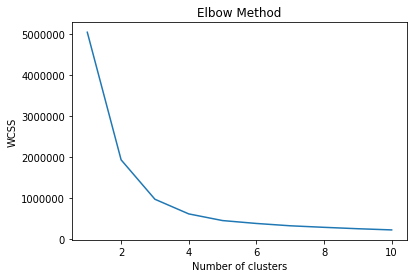

In [9]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

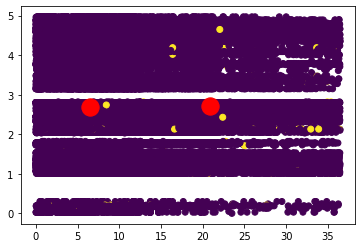

In [10]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(f1, f2, c=train2['is_attributed'])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

Trying to use PCA

In [128]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
trans_pca = train2.drop(['is_attributed'],axis=1)

Only one component accounts for 99 percent of the variance, therefore this model is bad.

In [129]:
trans_pca = pca.fit_transform(trans_pca)
pca.explained_variance_ratio_

array([0.99851347])

In [ ]:
rips = Rips(maxdim=1)
a = rips.fit_transform(train2)
plot_diagrams(a, show = True)

In [ ]:
#%pip install --upgrade --user scikit-learn

We will use ROC to see the area under curve for SVC and randomforestclassifier.
RandomForestClassifier gives better results as expected.
However, it's not the best!

In [13]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split

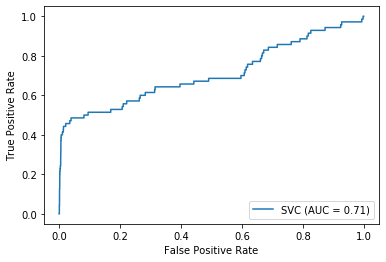

In [138]:
y = train2['is_attributed']
X1= train2.drop(['is_attributed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state=10, test_size=0.3)
svc = SVC(random_state=10, gamma = 'auto')
svc.fit(X_train, y_train)
svc_disp = plot_roc_curve(svc, X_test, y_test)
plt.show()

You can see that the area under curve is 0.93!
It's very close to perfect fit!

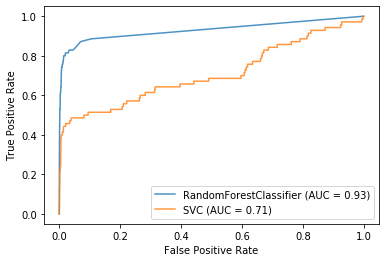

In [141]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=10)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

Log_Loss function scores are pretty less in both cases.

In [142]:
from sklearn.metrics import log_loss
print (log_loss(y_test, svc.predict(X_test)), log_loss(y_test, rfc.predict(X_test)))

0.08059047825479257 0.07022903190905308


Now we will use XGBOOST and tune it a little.
The area under curve increases to 0.95!

[0]	validation_0-error:0.002229	validation_1-error:0.002333
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.002157	validation_1-error:0.002333
[2]	validation_0-error:0.002214	validation_1-error:0.002333
[3]	validation_0-error:0.002214	validation_1-error:0.002333
[4]	validation_0-error:0.002143	validation_1-error:0.002333
[5]	validation_0-error:0.002143	validation_1-error:0.002333
[6]	validation_0-error:0.002143	validation_1-error:0.002333
[7]	validation_0-error:0.002143	validation_1-error:0.002333
[8]	validation_0-error:0.002143	validation_1-error:0.002333
[9]	validation_0-error:0.002143	validation_1-error:0.002333
[10]	validation_0-error:0.002114	validation_1-error:0.002333
[11]	validation_0-error:0.002129	validation_1-error:0.002333
[12]	validation_0-error:0.002043	validation_1-error:0.0023
[13]	validation_0-error:0.002057	validation_1-error:0.0022

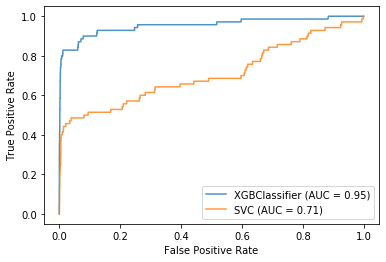

In [143]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(n_estimators = 150, learning_rate = 0.2,booster = 'gbtree', max_depth = 4, min_child_weight = 2, reg_lambda = 0.11, reg_alpha = 0.013)
eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgb.fit(X_train, y_train,eval_set = eval_set, early_stopping_rounds = 50)
ax = plt.gca()
xgb_disp = plot_roc_curve(model_xgb, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [81]:
from sklearn.model_selection import GridSearchCV

In [86]:
param_test1 = {
 'max_depth':range(3,8),
 'min_child_weight':range(1,6)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.2, n_estimators=150, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/home/tusharp/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([1.09902229, 1.1381072 , 1.08519001, 1.06573625, 1.02814951,
         1.21599116, 1.18778067, 1.16498747, 1.20787783, 1.13081164,
         1.46187234, 1.38961368, 1.40780053, 1.35369716, 1.32326994,
         1.65583501, 1.57778583, 1.50604224, 1.53554749, 1.34127936,
         1.72341208, 1.63398957, 1.61395082, 1.52606249, 1.42921133]),
  'std_fit_time': array([0.03798691, 0.03029646, 0.0802382 , 0.08059349, 0.08971784,
         0.12753248, 0.12866125, 0.11612514, 0.10885415, 0.07808446,
         0.15855984, 0.16248354, 0.16657973, 0.14528122, 0.14391093,
         0.22580927, 0.19398422, 0.17021083, 0.20580545, 0.03880652,
         0.03482192, 0.07030874, 0.19945159, 0.18017095, 0.16021143]),
  'mean_score_time': array([0.02283959, 0.02130785, 0.02097125, 0.02079005, 0.0196279 ,
         0.02442732, 0.02458119, 0.02400432, 0.02461419, 0.02440763,
         0.02956815, 0.02782936, 0.02705989, 0.02697382, 0.02828331,
         0.03194747, 0.03126783, 0.03056989, 0.

In [106]:
param_test6 = {
 'reg_alpha':[i/1000.0 for i in range(5,16)]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.2, n_estimators=150, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/home/tusharp/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([1.5118741 , 1.48330188, 1.37040524, 1.29067001, 1.22676735,
         1.21709056, 1.22219214, 1.221104  , 1.24361596, 1.24290061,
         1.23832116]),
  'std_fit_time': array([0.01077144, 0.11713379, 0.11619471, 0.117729  , 0.00887522,
         0.01008429, 0.01576625, 0.02042718, 0.02977636, 0.02362506,
         0.04776346]),
  'mean_score_time': array([0.03073487, 0.02749977, 0.02740602, 0.02557192, 0.02639828,
         0.02532892, 0.0250823 , 0.02503791, 0.0270987 , 0.02546988,
         0.02557869]),
  'std_score_time': array([0.00263323, 0.00117204, 0.00105664, 0.00075925, 0.0015173 ,
         0.00068675, 0.00072255, 0.00080481, 0.00165482, 0.0008445 ,
         0.00171468]),
  'param_reg_alpha': masked_array(data=[0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012,
                     0.013, 0.014, 0.015],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
   

In [119]:
param_test7 = {
 'reg_lambda':[i/1000.0 for i in range(105,115)]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.2, n_estimators=150, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

/home/tusharp/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([1.51443424, 1.4088182 , 1.45925269, 1.42782536, 1.38446555,
         1.39455347, 1.45797653, 1.46016035, 1.34319634, 1.42845125]),
  'std_fit_time': array([0.03195828, 0.14604648, 0.11917869, 0.15384659, 0.14233499,
         0.15021693, 0.11894423, 0.12698629, 0.15639638, 0.14967746]),
  'mean_score_time': array([0.03172512, 0.02744813, 0.02722573, 0.02857294, 0.02663689,
         0.02637153, 0.02679143, 0.02813077, 0.02725773, 0.0266305 ]),
  'std_score_time': array([0.00349278, 0.00206128, 0.00121961, 0.00222948, 0.00105406,
         0.00069192, 0.00019739, 0.00138788, 0.00219368, 0.00335841]),
  'param_reg_lambda': masked_array(data=[0.105, 0.106, 0.107, 0.108, 0.109, 0.11, 0.111, 0.112,
                     0.113, 0.114],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_lambda': 0.105},
   {'reg_lambda': 0.106},
   {'reg_

In [144]:
log_loss(y_test, model_xgb.predict(X_test))

0.06907765940281305

Now, we try to use PCA fit model. 
It performs poorly because of concentration of variance on a single feature.

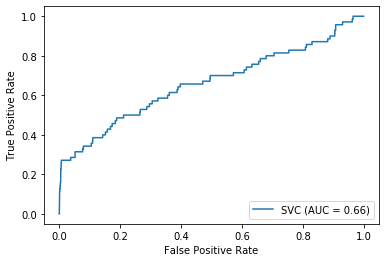

In [145]:
y = train2['is_attributed']
X_train, X_test, y_train, y_test = train_test_split(trans_pca, y, random_state=10, test_size=0.3)
svc = SVC(random_state=10, gamma = 'auto')
svc.fit(X_train, y_train)
svc_disp = plot_roc_curve(svc, X_test, y_test)
plt.show()

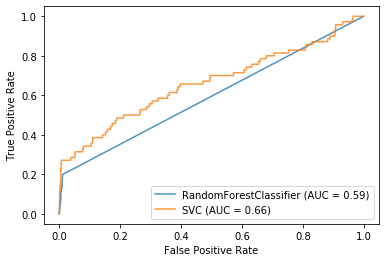

In [146]:
rfc = RandomForestClassifier(n_estimators=150, random_state=10)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [134]:
print (log_loss(y_test, svc.predict(X_test)) , log_loss(y_test, rfc.predict(X_test)))

0.08289311665428196 0.1174327459531182


In [147]:
model_xgb = xgb.XGBClassifier(n_estimators = 150, learning_rate = 0.2,booster = 'gbtree', max_depth = 4, min_child_weight = 2, reg_lambda = 0.11, reg_alpha = 0.013)
eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgb.fit(X_train, y_train,eval_set = eval_set, early_stopping_rounds = 50)
print(log_loss(y_test, model_xgb.predict(X_test)))


[0]	validation_0-error:0.002271	validation_1-error:0.002333
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.002271	validation_1-error:0.002333
[2]	validation_0-error:0.002271	validation_1-error:0.002333
[3]	validation_0-error:0.002271	validation_1-error:0.002333
[4]	validation_0-error:0.002271	validation_1-error:0.002333
[5]	validation_0-error:0.002271	validation_1-error:0.002333
[6]	validation_0-error:0.002271	validation_1-error:0.002333
[7]	validation_0-error:0.002271	validation_1-error:0.002333
[8]	validation_0-error:0.002271	validation_1-error:0.002333
[9]	validation_0-error:0.002271	validation_1-error:0.002333
[10]	validation_0-error:0.002271	validation_1-error:0.002333
[11]	validation_0-error:0.002271	validation_1-error:0.002333
[12]	validation_0-error:0.002271	validation_1-error:0.002333
[13]	validation_0-error:0.002271	validation_1-error:0.00

Therefore, the conclusion is, XGBClassifier models it the best and we have a decent AUC_ROC.